# Алгоритмы анализа данных
## Урок 7. Классификация с помощью KNN. Кластеризация K-means

In [1]:
import numpy as np
from sklearn import model_selection
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

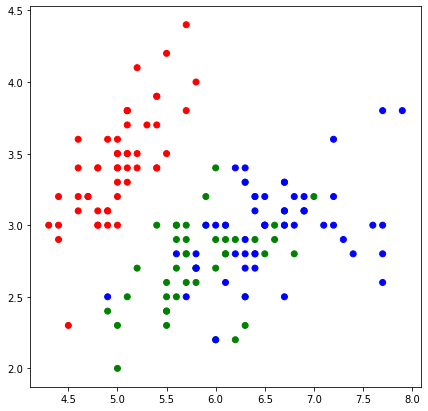

In [6]:
X, y = load_iris(return_X_y=True)

# Для наглядности возьмем только первые два признака (всего в датасете их 4)
X = X[:, :2]

# Разделим выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)

# Визуализируем их
cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap)
plt.show()

In [2]:
def e_metrics(x1, x2):
    """ Функция для подсчета евклидовой метрики.
    """
    distance = 0
    for i in range(len(x1)):
        distance += np.square(x1[i] - x2[i])
    
    return np.sqrt(distance)

In [3]:
def accuracy(pred, y):
    """Функция для вычисления точности.
    """
    return (sum(pred == y) / len(y))

In [38]:
def get_graph(X_train, y_train, k):
    """График распределения классов.
    """
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])

    h = .02

    # Расчет пределов графика
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Получим предсказания для всех точек
    Z = knn(X_train, y_train, np.c_[xx.ravel(), yy.ravel()], k)

    # Построим график
    Z = np.array(Z).reshape(xx.shape)
    plt.figure(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Добавим на график обучающую выборку
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"Трехклассовая kNN классификация при k = {k}")
    plt.show()

### Задача 1

К алгоритму kNN, реализованному на уроке, реализовать добавление весов для соседей по любому из показанных на уроке принципов.

**Решение**

In [39]:
def knn(x_train, y_train, x_test, k):
    """Алгоритм поиска k ближайших соседей.
    """
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        sorted_distances = sorted(test_distances)[0:k]
        k_dist_sum = sum([d[0] for d in sorted_distances])
        for d in sorted_distances:
            classes[d[1]] += 1 - d[0] / k_dist_sum
            
        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
    return answers

Точность алгоритма при k = 3: 0.767


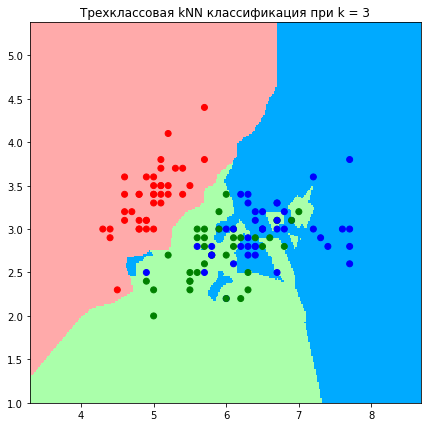

CPU times: user 43.7 s, sys: 201 ms, total: 43.9 s
Wall time: 44.2 s


In [40]:
%%time

k = 3

y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

get_graph(X_train, y_train, k)

Точность алгоритма при k = 10: 0.867


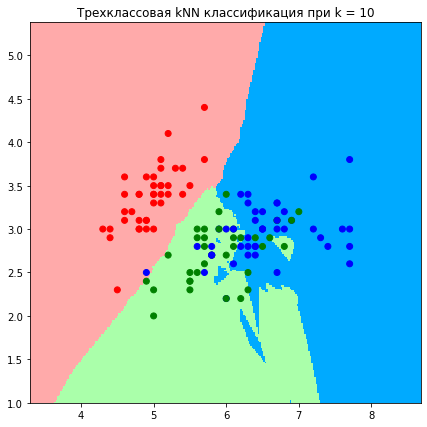

CPU times: user 45.2 s, sys: 218 ms, total: 45.4 s
Wall time: 45.7 s


In [41]:
%%time

k = 10

y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

get_graph(X_train, y_train, k)

### Задание 2*

Написать функцию подсчета метрики качества кластеризации как среднее квадратичное внутриклассовое расстояние и построить 
график ее зависимости от количества кластеров k (взять от 1 до 10) для выборки данных из данного урока (создать датасет, как в методичке).

**Решение**

In [42]:
from sklearn.datasets import make_blobs
import random

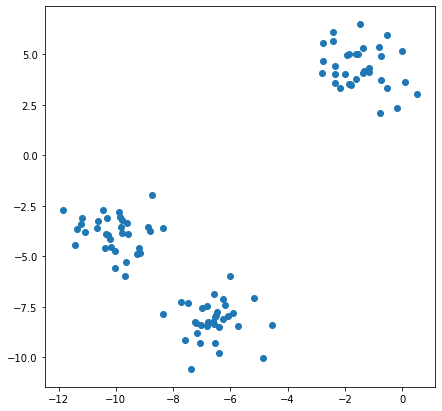

In [43]:
# Сгенерируем три облака точек с помощью инструментов sklearn
X, y = make_blobs(n_samples=100, random_state=1)

# Изобразим точки на графике
plt.figure(figsize=(7,7))
plt.scatter(X[:, 0], X[:, 1])
plt.show()

In [77]:
def kmeans(data, k, max_iterations, min_distance):
    # инициализируем центроиды как первые k элементов датасета
    centroids = [data[i] for i in range(k)]
    
    for _ in range(max_iterations):
        # обнулим словарь для классификации
        classes = {i: [] for i in range(k)}
    
        # классифицируем объекты по центроидам
        for x in data:
            # определим расстояния от объекта до каждого центроида
            distances = [e_metrics(x, centroid) for centroid in centroids]
            # отнесем объект к кластеру, до центроида которого наименьшее расстояние
            classification = distances.index(min(distances))
            classes[classification].append(x)
        
        # сохраним предыдущие центроиды в отдельный список для последующего сравнения сновыми
        old_centroids = centroids.copy()
        
        # пересчитаем центроиды как среднее по кластерам
        for classification in classes:
            centroids[classification] = np.average(classes[classification], axis=0)
            
        # сравним величину смещения центроидов с минимальной
        optimal = True
        for centroid in range(len(centroids)):
            if np.sum(abs((centroids[centroid] - old_centroids[centroid]) / old_centroids * 100)) > min_distance:
                optimal = False
                
        # если все смещения меньше минимального, останавливаем алгоритм  
        if optimal:
            break
    
    return old_centroids, classes

In [45]:
def visualize(centroids, classes):
    """Функция визуализации кластеров
    """
    colors = ['r', 'g', 'b']
    
    plt.figure(figsize=(7,7))
    
    # нанесем на график центроиды
    for centroid in centroids:
        plt.scatter(centroid[0], centroid[1], marker='x', s=130, c='black')
        
    # нанесем объекты раскрашенные по классам
    for class_item in classes:
        for x in classes[class_item]:
            plt.scatter(x[0], x[1], color=colors[class_item])
            
    plt.show()

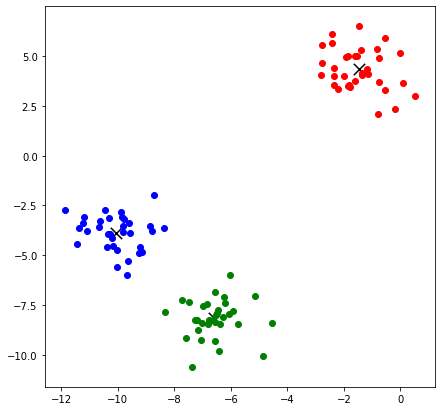

CPU times: user 334 ms, sys: 7.72 ms, total: 342 ms
Wall time: 345 ms


In [112]:
%%time

# определим максимальное количество итераций
max_iterations = 4

# и минимальное расстояние между центроидами до пересчета и после него, при котором нужно остановить алгоритм
min_distance = 1e-4

# сразу определим известное нам количество кластеров
k = 3

# Проверим результат алгоритма
centroids, clusters = kmeans(X, k, max_iterations, min_distance)
visualize(centroids, clusters)

In [113]:
def kmeans_mse(centroids, clusters):
    k = len(centroids)
    centroids_mse = []
    for i in range(k):
        centroids_mse.extend(e_metrics(np.array(centroids[i]), item)**2 for item in clusters[i])
    return np.average(centroids_mse)

In [114]:
print(f'Для {k} кластеров mse = {kmeans_mse(centroids, clusters)}')

Для 3 кластеров mse = 1.5628289251170002


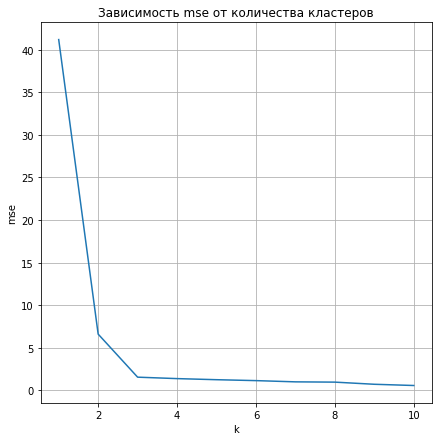

In [115]:
vals = []

for k in range(1, 11):
    max_iterations = 10
    min_distance = 1e-4
    centroids, clusters = kmeans(X, k, max_iterations, min_distance)
    mse = kmeans_mse(centroids, clusters)
    vals.append((k, mse))

plot_vals = np.transpose(np.array(vals))
plt.figure(figsize=(7,7))
plt.plot(plot_vals[0], plot_vals[1])
plt.title("Зависимость mse от количества кластеров")
plt.xlabel("k")
plt.ylabel("mse")
plt.grid(True)
plt.show()